In [13]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
from scipy.spatial import Delaunay
roi = '$\\ell_pER$'

In [14]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
from reporting_regen_hull import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
main_df["orientation"] = main_df["orientation"].fillna("fourier", inplace=False)
main_df_all = main_df.copy()
main_df = main_df[main_df["failure_type"] == "pass"]
np.random.seed(0)

In [15]:
main_df = regenerate_hulls(sample_limit= 5000)
main_df["orientation"] = main_df["orientation"].fillna("fourier", inplace=False)

100%|██████████| 126/126 [01:00<00:00,  2.09it/s]


Main DF (before frequency): (2199, 45)
Main DF (after frequency): (2199, 46)
Main DF (after result categorization): (2202, 48)


In [16]:
def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

def get_hull_centroid(hull, log =False):
    # Extract ordered convex hull vertices
    polygon = hull.points[hull.vertices]
    if log:
        polygon = np.log10(polygon)

    # Close the polygon if needed
    if not np.allclose(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])

    x, y = polygon[:, 0], polygon[:, 1]
    cross = x[:-1] * y[1:] - x[1:] * y[:-1]
    area = 0.5 * np.sum(cross)

    if np.isclose(area, 0):
        return np.mean(polygon, axis=0)  # fallback for degenerate polygon

    cx = np.sum((x[:-1] + x[1:]) * cross) / (6 * area)
    cy = np.sum((y[:-1] + y[1:]) * cross) / (6 * area)

    return np.array([cx, cy])
def in_hull_list(p, hulls):
   return np.any([in_hull(p, hull) for hull in hulls], axis=0)

# Point + Pointalism Plot

In [26]:
fontsize = 20
markersize = 30
labelsize = 15
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
]

color_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

fit_cat_palette = {
    'actually_pass': 'green',
    'practically_pass': 'xkcd:pastel orange',
    'borderline': 'xkcd:golden yellow',
    'interesting_failure': 'xkcd:light red',
    'trivial_failure': 'red'
}

transform_palette = {
    'wavelet': 'xkcd:light purple',
    'fourier': 'xkcd:red',
     'gabor' : 'xkcd:yellow orange',
    'learned': 'xkcd:marine blue'
}

temp = main_df.copy().sort_values(['failure_category', 'transform'])

fontsize=35
r_valid = (temp['best_r'].min() - 0.05, temp['best_r'].max())
eta_valid = (-1.5, 20)
xlims = (r_valid[0] - 0.1, r_valid[1] + 0.1)
eta_lims = (-3, 21)
ylims = (eta_valid[0] - 0.1, eta_valid[1] + 0.1)

r_roi = (temp['best_r'].min() - 0.5, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = (1.5 + eta_valid[1]) / r_vals
beta_vals_below = (1.5 + (-1.4)) / r_vals

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
r_vals_roi = np.where(r_vals_roi == 0, 1e-10, r_vals_roi)  # Replace zero with a small positive value
beta_vals_roi_above = (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = beta_border

In [27]:
pastis_region_data = main_df[(main_df['dataset'] == 'pastis') & (main_df['transform'] == 'fourier') 
                             & (main_df['channel'] == 'gray') & (main_df['group'] == 8)].iloc[0]
spaceNet_region_data = main_df[(main_df['dataset'] == 'spaceNet') & (main_df['transform'] == 'wavelet') 
                               & (main_df['orientation'] == 'horizVert') & (main_df['channel'] == 'gray') 
                               & (main_df['group'] == 9)].iloc[0]


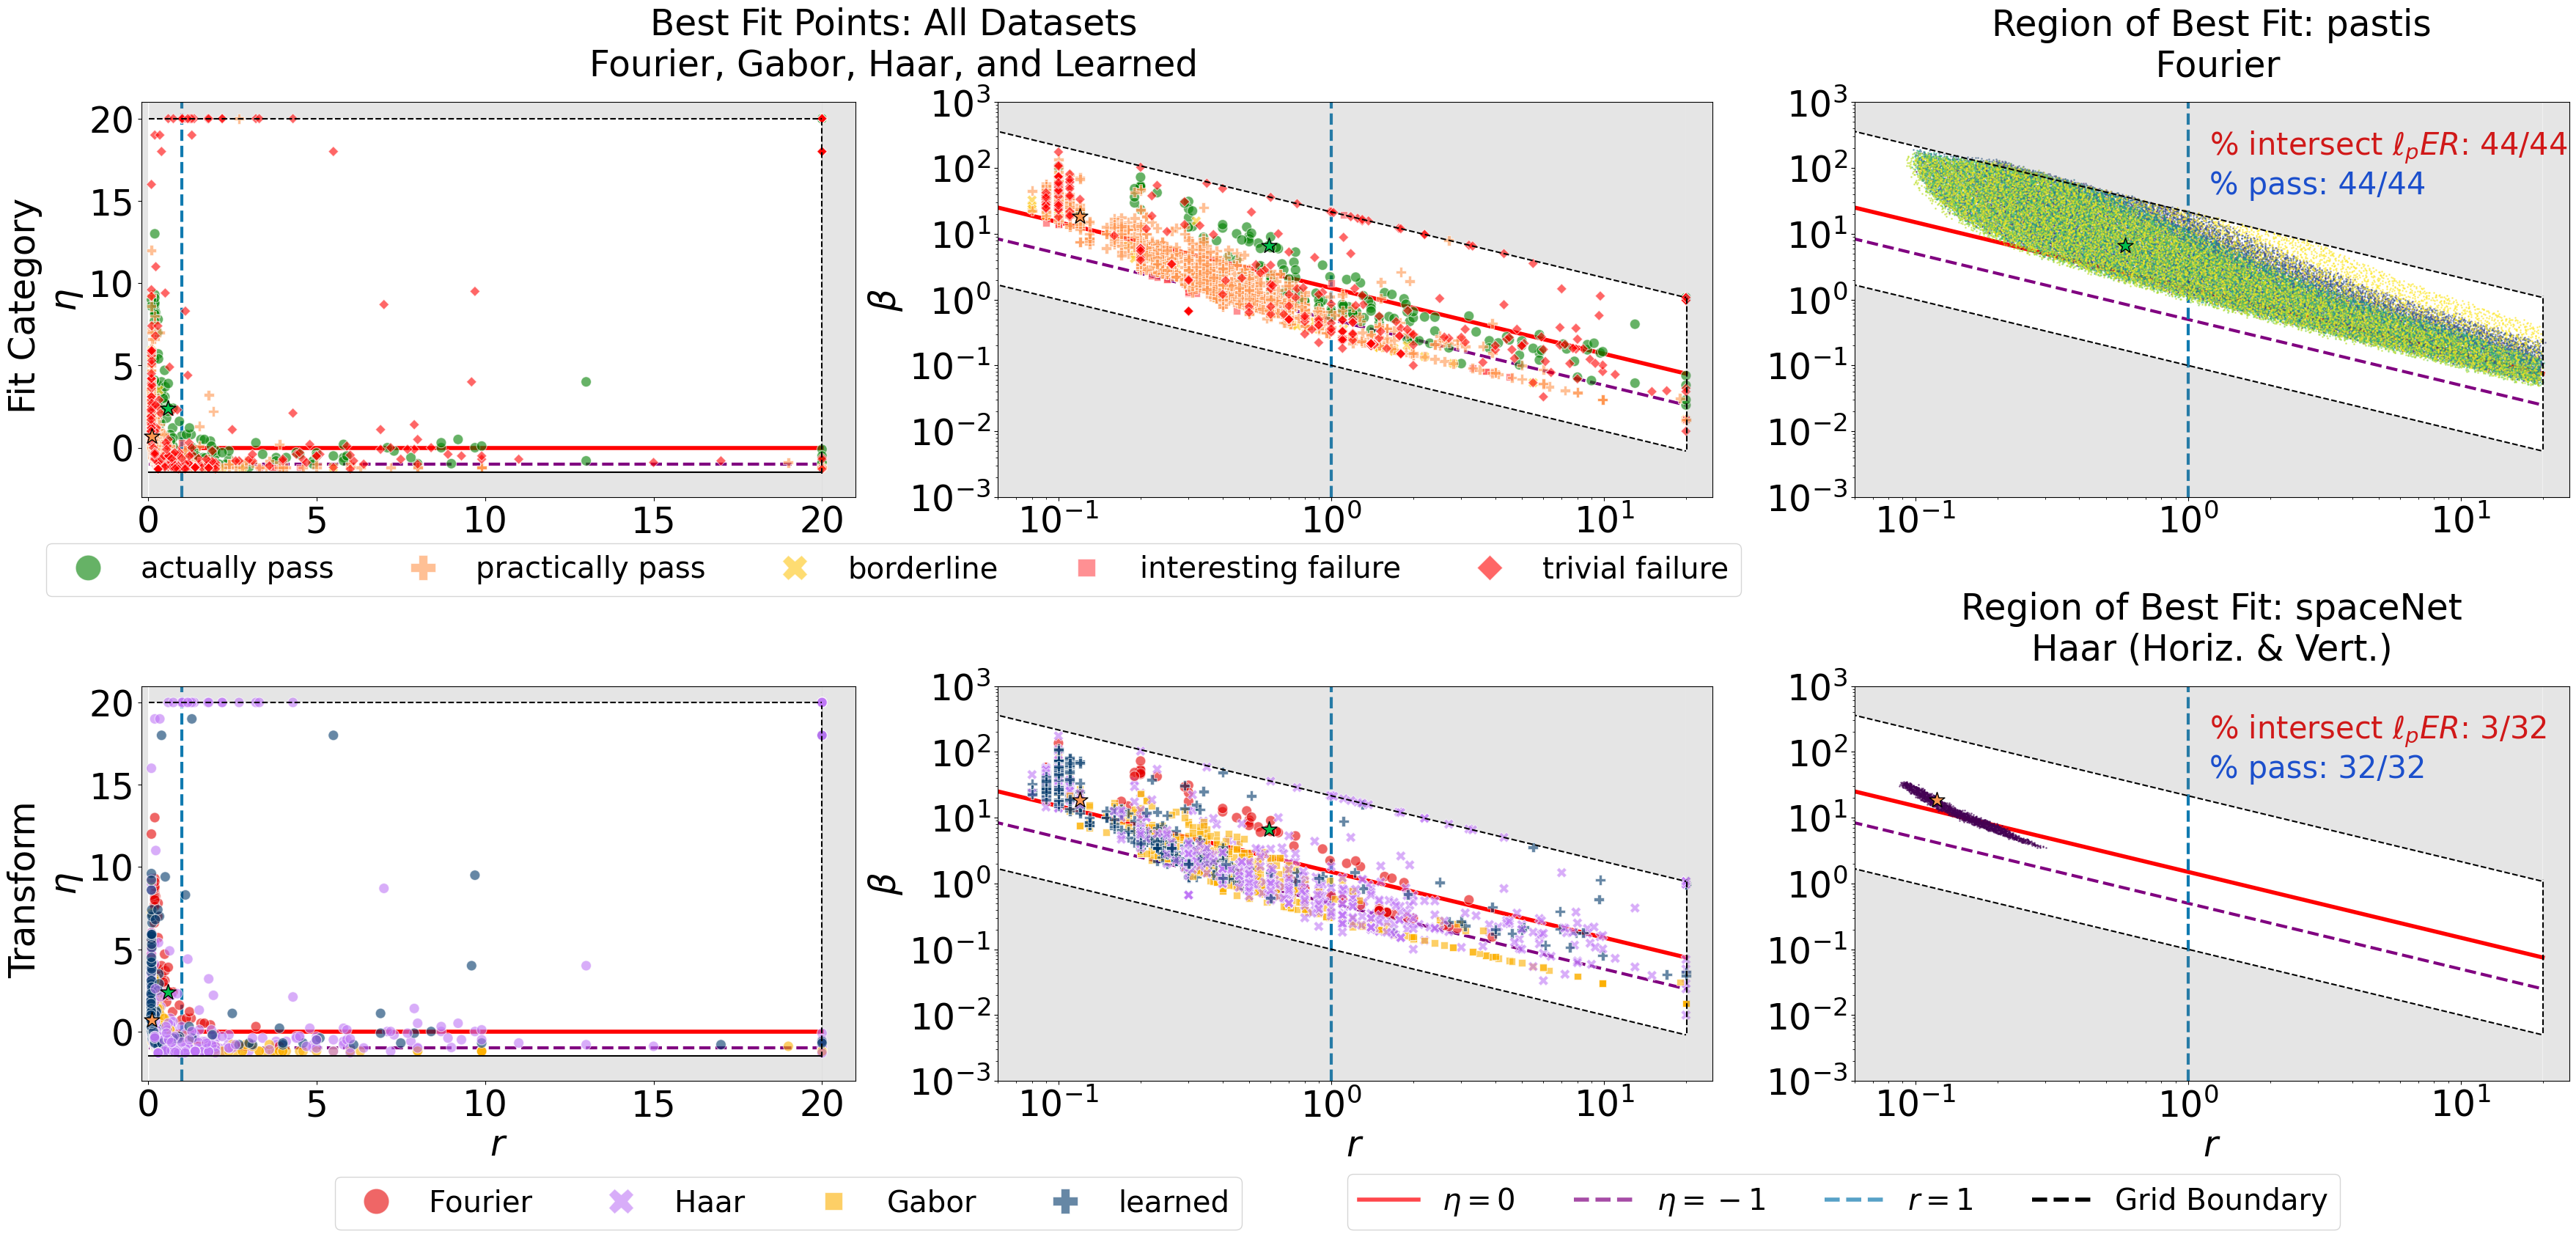

In [28]:
category_1 = 'failure_category'
category_2 = 'transform'

fig, axes = plt.subplots(2, 3, figsize=(36, 16))

# First row, first plot: r-eta space with failure categories
axes[0, 0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[0, 0].fill_between(r_vals, y1=eta_valid[1], y2=21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[0, 0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[0, 0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[0, 0], linestyle='--')
axes[0, 0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[0, 0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)
axes[0, 0].fill_betweenx(y=[-5, 1e3], x1=-2, x2=0, color='gray', alpha=0.2, ec=None)
axes[0, 0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0, 0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue=category_1, ax=axes[0, 0], alpha=0.6, s=100, palette=fit_cat_palette, style=category_1)
axes[0, 0].scatter(pastis_region_data['best_r'], pastis_region_data['best_eta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
axes[0, 0].scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_eta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')

axes[0, 0].set_xlabel(" ", fontsize=fontsize)
axes[0, 0].set_ylabel("Fit Category \n" + r"$\eta$", fontsize=fontsize)
axes[0, 0].set_ylim(eta_lims)
axes[0, 0].set_xlim((-0.2, 21))
axes[0, 0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0, 0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# First row, second plot: r-(1/beta) space with failure categories
axes[0, 1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[0, 1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[0, 1], linestyle="--")
axes[0, 1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+1e3, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[0, 1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[0, 1], linestyle='--', linewidth=3, zorder=0)
axes[0, 1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue=category_1, ax=axes[0, 1], alpha=0.6, s=100, palette=fit_cat_palette, style=category_1)
axes[0, 1].axvline(x=20.1, ymin=0.12, ymax=0.51, color='black', linestyle='dashed')
axes[0, 1].fill_betweenx(y=[-1.4, 1e3], x1=20, x2=1e2, color='gray', alpha=0.2, ec=None)
axes[0, 1].scatter(pastis_region_data['best_r'], pastis_region_data['best_beta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
axes[0, 1].scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_beta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')


axes[0, 1].set_xlabel(" \n \n ", fontsize=fontsize)
axes[0, 1].set_ylabel(r'$\beta$', fontsize=fontsize)
axes[0, 1].set_xlim((0.06, 25))
axes[0, 1].set_ylim((0.001, 1e3))
axes[0, 1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_yscale('log')





axes[0, 1].legend().set_visible(False)
axes[0, 0].legend().set_visible(False)

# Second row, first plot: r-eta space with dataset_types

axes[1, 0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[1, 0].fill_between(r_vals, y1=eta_valid[1], y2=21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[1, 0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[1, 0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[1, 0], linestyle='--')
axes[1, 0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[1, 0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)
axes[1, 0].fill_betweenx(y=[-5, 1e3], x1=-2, x2=0, color='gray', alpha=0.2, ec=None)

axes[1, 0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[1, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[1, 0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue=category_2, ax=axes[1, 0], alpha=0.6, s=100, palette=transform_palette)
axes[1, 0].scatter(pastis_region_data['best_r'], pastis_region_data['best_eta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
axes[1, 0].scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_eta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')


axes[1, 0].set_xlabel(r"$r$", fontsize=fontsize)
axes[1, 0].set_ylabel(f"{category_2.capitalize()} \n" + r"$\eta$", fontsize=fontsize)
axes[1, 0].set_ylim(eta_lims)
axes[1, 0].set_xlim((-0.2, 21))
axes[1, 0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1, 0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# Second row, second plot: r-(1/beta) space with failure categories
axes[1, 1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1, 1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1, 1], linestyle="--")
axes[1, 1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+1e3, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[1, 1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[1, 1], linestyle='--', linewidth=3, zorder=0)
axes[1, 1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue=category_2, ax=axes[1, 1], alpha=0.6, s=100, style=category_2, palette=transform_palette)
axes[1, 1].axvline(x=20.1, ymin=0.12, ymax=0.51, color='black', linestyle='dashed')
axes[1, 1].fill_betweenx(y=[-1.4, 1e3], x1=20, x2=1e3, color='gray', alpha=0.2, ec=None)
axes[1, 1].scatter(pastis_region_data['best_r'], pastis_region_data['best_beta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
axes[1, 1].scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_beta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')

axes[1, 1].set_xlabel(r"$r$", fontsize=fontsize)
axes[1, 1].set_ylabel(r'$\beta$', fontsize=fontsize)
axes[1, 1].set_xlim((0.06, 25))
axes[1, 1].set_ylim((0.001, 1e3))
axes[1, 1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
    

axes[1, 1].legend().set_visible(False)
axes[1, 0].legend().set_visible(False)

# Add a centered annotation above the first two columns
fig.text(
    0.34, 0.93, "Best Fit Points: All Datasets\nFourier, Gabor, Haar, and Learned",
    fontsize=fontsize,
    ha='center',
    va='bottom'
)


from sympy import Line2D
from matplotlib.lines import Line2D


num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("pastis", "full")
direction = "fourier"



global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

## SPECIFIC DIRECTION PLOTTING
ax = axes[0, 2]

df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df_all["transform"] == "fourier") & (main_df["orientation"] == direction)].copy()
df_no_drop = df.copy()
df = df.dropna(subset=["hull"])
df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] == "fourier") & (main_df_all["orientation"] == direction)].copy()
group_list = df["group"].unique()
hull_list = []
all_hulls = []
for group in group_list:
    hull_list.append(df[df["group"] == group]["hull"])
    all_hulls.extend(df[df["group"] == group]["hull"])
if len(all_hulls) == 0:
    raise ValueError("No hulls found for the specified criteria.")
all_points = np.vstack([hull.points for hull in all_hulls])
xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


if xmax > global_xmax:
    global_xmax = xmax
if ymax > global_ymax:
    global_ymax = ymax
if xmin < global_xmin:
    global_xmin = xmin
if ymin < global_ymin:
    global_ymin = ymin
    
color_map = plt.get_cmap('viridis')
num_groups = len(group_list)
group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

xx, yy = np.meshgrid(x_vals, y_vals)
points_grid = np.c_[xx.ravel(), yy.ravel()]
for k, hull in enumerate(hull_list):
    hull_mask = in_hull_list(points_grid, hull)
    points = points_grid[hull_mask]
    points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
    ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
ax.set_xlabel("r")
ax.set_ylabel("beta")
ax.set_xscale('log')
ax.set_yscale('log')
temp_df = df[df["orientation"] == direction]
#ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")


pass_percent = f"{len(df_no_drop)}/{len(df_all)}"

intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(df_no_drop)}"
ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
    textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='left', 
    bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
    textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='left', 
    bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)




ax.fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=ax, linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=ax, linestyle="--")
ax.fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+1e3, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=ax, linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=ax, linestyle='--', linewidth=3, zorder=0)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
ax.fill_betweenx(y=[-1.4, 1e3], x1=20, x2=1e3, color='gray', alpha=0.2, ec=None)
ax.scatter(pastis_region_data['best_r'], pastis_region_data['best_beta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
# ax.scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_beta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')
ax.axvline(x=20.1, ymin=0.12, ymax=0.51, color='black', linestyle='dashed')

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.set_ylabel(r' ', fontsize=fontsize)
ax.set_xlim((0.06, 25))
ax.set_ylim((0.001, 1e3))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    ax.set_xscale('log')
    ax.set_yscale('log')

### LABELS AND LEGENDS
ax.set_title("Region of Best Fit: pastis\n Fourier", fontsize = fontsize, y=1.05)
ax.set_ylabel(r" ", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        

ax.legend().set_visible(False)

num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("spaceNet", "full")
direction = "horizVert"


# Add a fourth column to the right for the new plot
global_xmax = 20.00282856860364
global_ymax = 22.22193325014087
global_xmin = 0.09087556048135428
global_ymin = 0.004902068337936946


## SPECIFIC DIRECTION PLOTTING
ax = axes[1, 2]

df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df["transform"] == "wavelet") & (main_df["orientation"] == direction)].copy()
df_no_drop = df.copy()
df = df.dropna(subset=["hull"])
df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] == "wavelet") & (main_df_all["orientation"] == direction)].copy()
group_list = df["group"].unique()
hull_list = []
all_hulls = []
for group in group_list:
    hull_list.append(df[df["group"] == group]["hull"])
    all_hulls.extend(df[df["group"] == group]["hull"])
if len(all_hulls) == 0:
    raise ValueError("No hulls found for the specified criteria.")
all_points = np.vstack([hull.points for hull in all_hulls])
xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


if xmax > global_xmax:
    global_xmax = xmax
if ymax > global_ymax:
    global_ymax = ymax
if xmin < global_xmin:
    global_xmin = xmin
if ymin < global_ymin:
    global_ymin = ymin
    
color_map = plt.get_cmap('viridis')
num_groups = len(group_list)
group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

xx, yy = np.meshgrid(x_vals, y_vals)
points_grid = np.c_[xx.ravel(), yy.ravel()]
for k, hull in enumerate(hull_list):
    hull_mask = in_hull_list(points_grid, hull)
    points = points_grid[hull_mask]
    points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
    ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
ax.set_xlabel("r")
ax.set_ylabel("beta")
ax.set_xscale('log')
ax.set_yscale('log')
temp_df = df[df["orientation"] == direction]
#ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")


pass_percent = f"{len(df_no_drop)}/{len(df_all)}"

intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(df_no_drop)}"
ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
    textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='left', 
    bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
    textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='left', 
    bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)

ax.fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=ax, linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=ax, linestyle="--")
ax.fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+1e3, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=ax, linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=ax, linestyle='--', linewidth=3, zorder=0)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
ax.fill_betweenx(y=[-1.4, 1e3], x1=20, x2=1e3, color='gray', alpha=0.2, ec=None)
ax.axvline(x=20.1, ymin=0.12, ymax=0.51, color='black', linestyle='dashed')
# ax.scatter(pastis_region_data['best_r'], pastis_region_data['best_beta'], color='xkcd:shamrock green', marker='*', s=250, zorder=10, ec='black')
ax.scatter(spaceNet_region_data['best_r'], spaceNet_region_data['best_beta'], color='xkcd:pastel orange', marker='*', s=250, zorder=10, ec='black')

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.set_ylabel(r' ', fontsize=fontsize)
ax.set_xlim((0.06, 25))
ax.set_ylim((0.001, 1e3))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    ax.set_xscale('log')
    ax.set_yscale('log')

### LABELS AND LEGENDS
ax.set_title("Region of Best Fit: spaceNet\nHaar (Horiz. & Vert.)", fontsize = fontsize, y=1.05)
ax.set_ylabel(r" ", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        
ax.legend().set_visible(False)

handles_fit, labels_fit = axes[0, 0].get_legend_handles_labels()
labels_fit = [l.replace("_", " ") for l in labels_fit]

desired_order_fit = ['actually pass', 'practically pass', 'borderline', 'interesting failure', 'trivial failure']
label_handle_map_fit = dict(zip(labels_fit, handles_fit))

labels_fit = [label for label in desired_order_fit if label in label_handle_map_fit]
handles_fit = [label_handle_map_fit[label] for label in labels_fit]

fig.legend(
    handles_fit, 
    labels_fit, 
    markerscale=2.5, 
    fontsize=fontsize-6, 
    loc='lower center', 
    bbox_to_anchor=(0.34, 0.48), 
    ncol=5
)

handles, labels = axes[1, 1].get_legend_handles_labels()

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$", alpha=0.7),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$', alpha=0.7),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]


fig.legend(
    handles,
    ['Fourier', 'Haar', 'Gabor', 'learned'],
    markerscale=2.5,
    fontsize=fontsize-6,
    loc='lower center',
    bbox_to_anchor=(0.30, -0.06),
    ncol=len(handles)
)
fig.legend(
    legend_elements,
    [le.get_label() for le in legend_elements],
    markerscale=2.5,
    fontsize=fontsize-6,
    loc='lower center',
    bbox_to_anchor=(0.7, -0.06),
    ncol=len(legend_elements)
)

# === Add extra space only between the 2nd and 3rd column (i.e., columns 1 and 2) ===
# Get positions of the 2nd and 3rd column axes in both rows
pos2_row0 = axes[0, 1].get_position()
pos2_row1 = axes[1, 1].get_position()
pos3_row0 = axes[0, 2].get_position()
pos3_row1 = axes[1, 2].get_position()

# Amount to shift the 3rd column to the right
shift = 0.5  # Adjust as needed for desired whitespace

# Shift the 3rd column axes to the right
axes[0, 2].set_position([
    pos3_row0.x0 + shift, pos3_row0.y0, pos3_row0.width, pos3_row0.height
])
axes[1, 2].set_position([
    pos3_row1.x0 + shift, pos3_row1.y0, pos3_row1.width, pos3_row1.height
])


plt.subplots_adjust(hspace=0.9)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"where_parameters_lie.jpg")
    fig.savefig(save_path, dpi=DPI, bbox_inches='tight')


In [20]:
labels


['fourier', 'wavelet', 'gabor', 'learned']

In [21]:
df_all

,group,dataset,subset,transform,orientation,channel,dataset_type,obs_var,var_lower,var_upper,...,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma,github_plot,total_samples,beat_all_priors,best_prior,failure_category,failure_type
1842,2,spaceNet,full,wavelet,horizVert,blue,remote sensing,17165.906000,16108.417000,18292.635000,...,65.997600,0.031033,3.367790e-23,0.000856,https://github.com/yashdave003/hierarchical-ba...,27208.0,1,GenGamma,practically_pass,pass
1843,3,spaceNet,full,wavelet,horizVert,blue,remote sensing,4524.586400,4128.137000,4992.156000,...,12.937300,0.131600,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,108832.0,1,GenGamma,trivial_failure,spike-and-slab
1844,4,spaceNet,full,wavelet,horizVert,blue,remote sensing,1373.497800,1260.059900,1500.446500,...,9.473620,0.091444,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,333298.0,1,GenGamma,trivial_failure,spike-and-slab
1845,5,spaceNet,full,wavelet,horizVert,blue,remote sensing,373.974330,342.442600,411.004360,...,5.505940,0.075152,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,1149538.0,1,GenGamma,trivial_failure,spike-and-slab
1846,6,spaceNet,full,wavelet,horizVert,blue,remote sensing,90.558540,82.760320,99.773340,...,3.052540,0.059970,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,4251250.0,1,GenGamma,borderline,large peak
1847,7,spaceNet,full,wavelet,horizVert,blue,remote sensing,20.864730,18.737272,23.678892,...,1.291110,0.062294,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,17005000.0,1,GenGamma,practically_pass,pass
1848,8,spaceNet,full,wavelet,horizVert,blue,remote sensing,4.538293,3.987122,5.320569,...,0.574938,0.052063,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,68020000.0,1,GenGamma,practically_pass,pass
1849,9,spaceNet,full,wavelet,horizVert,blue,remote sensing,0.850477,0.718634,1.177882,...,0.301594,0.028648,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,272080000.0,1,GenGamma,practically_pass,pass
1850,2,spaceNet,full,wavelet,horizVert,gray,remote sensing,18631.910000,17458.344000,19881.506000,...,68.159200,0.032054,1.011360e-24,0.000093,https://github.com/yashdave003/hierarchical-ba...,27208.0,1,GenGamma,practically_pass,pass
1851,3,spaceNet,full,wavelet,horizVert,gray,remote sensing,4980.927200,4541.654300,5492.933600,...,13.619300,0.132950,0.000000e+00,0.000000,https://github.com/yashdave003/hierarchical-ba...,108832.0,1,GenGamma,trivial_failure,spike-and-slab


In [22]:
main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & 
        (main_df["transform"] != "learned") & (main_df["orientation"] == direction)
        & (~main_df["hull"].isna())].copy()

,dataset,subset,transform,group,orientation,channel,dataset_type,obs_var,var_lower,var_upper,...,kstest_pval_t,kstest_pval_gengamma,github_plot,best_beta,best_1/beta,beat_all_priors,best_prior,frequency,failure_category,failure_type
1849,spaceNet,full,wavelet,9,horizVert,blue,remote sensing,0.850477,0.718634,1.177882,...,0.0,0.0,https://github.com/yashdave003/hierarchical-ba...,28.000000,0.035714,1,GenGamma,0.996109,practically_pass,pass
1857,spaceNet,full,wavelet,9,horizVert,gray,remote sensing,0.898377,0.752576,1.277669,...,0.0,0.0,https://github.com/yashdave003/hierarchical-ba...,18.333333,0.054545,1,GenGamma,0.996109,practically_pass,pass
1865,spaceNet,full,wavelet,9,horizVert,green,remote sensing,1.022354,0.857071,1.428720,...,0.0,0.0,https://github.com/yashdave003/hierarchical-ba...,18.333333,0.054545,1,GenGamma,0.996109,practically_pass,pass
1873,spaceNet,full,wavelet,9,horizVert,red,remote sensing,0.722777,0.589432,1.182955,...,0.0,0.0,https://github.com/yashdave003/hierarchical-ba...,33.333333,0.030000,1,GenGamma,0.996109,practically_pass,pass


0.0878345565955656 20.00276047359689 0.00508031837956902 33.3346174706651


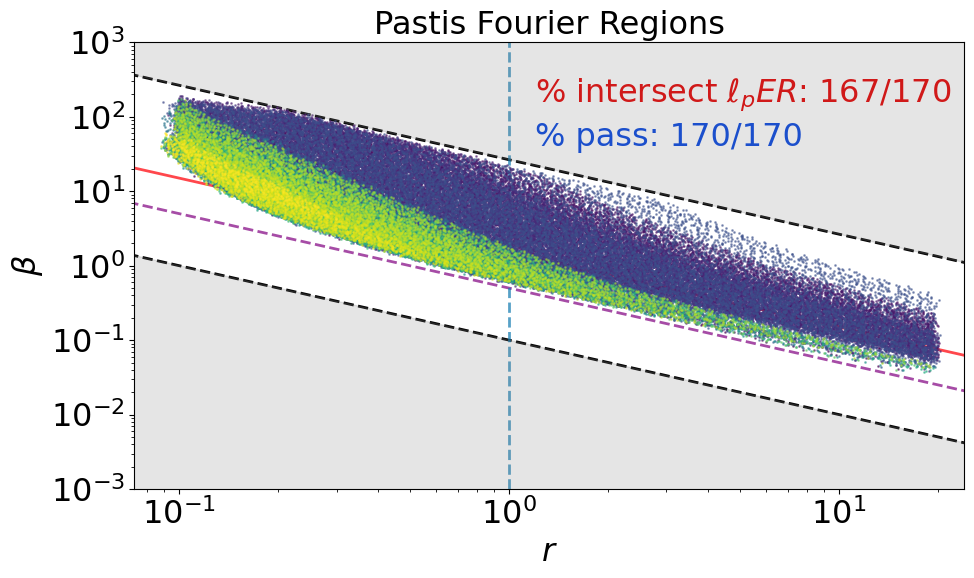

In [23]:
from sympy import Line2D
from matplotlib.lines import Line2D


num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("pastis", "full")
direction = "fourier"
fontsize=23
dataset_fontsize = 40


# Add a fourth column to the right for the new plots
fig, ax = plt.subplots(figsize=(10, 6))
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

## SPECIFIC DIRECTION PLOTTING
if direction != "all":
    df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
    group_list = df["group"].unique()
    hull_list = []
    all_hulls = []
    for group in group_list:
        hull_list.append(df[df["group"] == group]["hull"])
        all_hulls.extend(df[df["group"] == group]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


    if xmax > global_xmax:
        global_xmax = xmax
    if ymax > global_ymax:
        global_ymax = ymax
    if xmin < global_xmin:
        global_xmin = xmin
    if ymin < global_ymin:
        global_ymin = ymin
        
    color_map = plt.get_cmap('viridis')
    num_groups = len(group_list)
    group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
    ax.set_xlabel("r")
    ax.set_ylabel("beta")
    ax.set_xscale('log')
    ax.set_yscale('log')
    temp_df = df[df["orientation"] == direction]
    #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
    ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    

### ALL DIRECTIONS PLOTTING
else:
    ax4 = ax
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax4.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=10, fontsize=fontsize-6)


### GLOBAL BOUNDARIES AND ROI PLOTTING
x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
eta_vals_global = 0 * np.zeros_like(x_vals_global)
eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
eta_neg_1 = -1 + np.zeros_like(x_vals_global)

roi_global = (eta_vals_global + 1.5) / x_vals_global
roi_lower = (eta_roi_lower + 1.5) / x_vals_global
roi_upper = (eta_roi_upper + 1.5) / x_vals_global
beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global

ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
#ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.7)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.7)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)


ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
#ax.set_ylim(ylim)
ax.set_ylim([1e-3, 1e3])




### LABELS AND LEGENDS
plt.title("Pastis Fourier Regions", fontsize = fontsize)
ax.set_ylabel(r"$\beta$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$", alpha=0.7),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$', alpha=0.7),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

#fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize-5, bbox_to_anchor=(0.5, -0.075), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])


print(global_xmin, global_xmax, global_ymin, global_ymax)
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_pastis_fourier.png"), bbox_inches='tight', dpi=DPI)

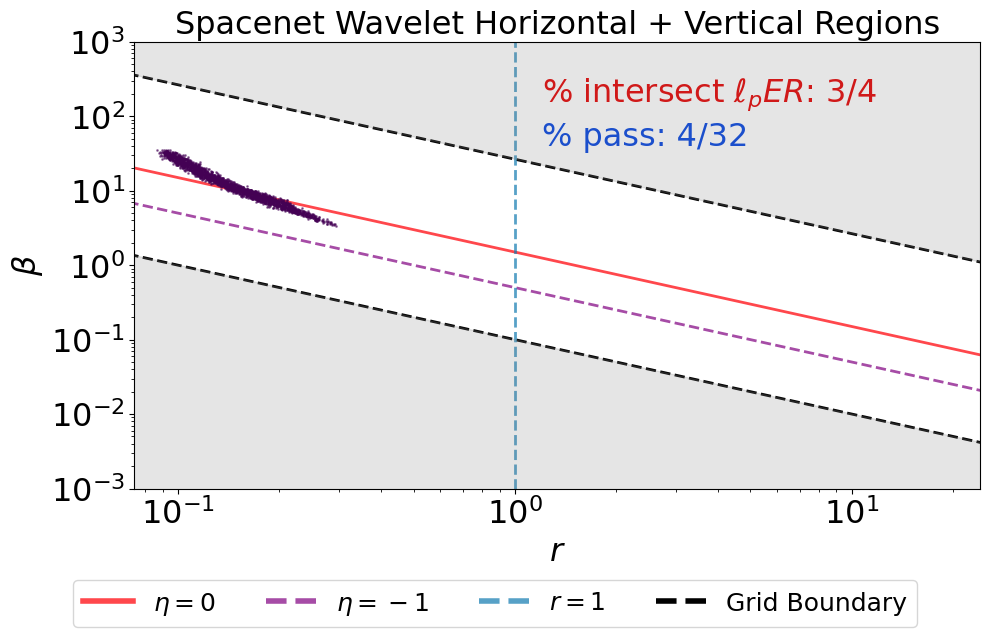

In [24]:
from sympy import Line2D
from matplotlib.lines import Line2D


num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("spaceNet", "full")
direction = "horizVert"
fontsize=23
dataset_fontsize = 40


# Add a fourth column to the right for the new plots
fig, ax = plt.subplots(figsize=(10, 6))
global_xmax = 20.00282856860364
global_ymax = 22.22193325014087
global_xmin = 0.09087556048135428
global_ymin = 0.004902068337936946

## SPECIFIC DIRECTION PLOTTING
if direction != "all":
    df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
    group_list = df["group"].unique()
    hull_list = []
    all_hulls = []
    for group in group_list:
        hull_list.append(df[df["group"] == group]["hull"])
        all_hulls.extend(df[df["group"] == group]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


    if xmax > global_xmax:
        global_xmax = xmax
    if ymax > global_ymax:
        global_ymax = ymax
    if xmin < global_xmin:
        global_xmin = xmin
    if ymin < global_ymin:
        global_ymin = ymin
        
    color_map = plt.get_cmap('viridis')
    num_groups = len(group_list)
    group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
    ax.set_xlabel("r")
    ax.set_ylabel("beta")
    ax.set_xscale('log')
    ax.set_yscale('log')
    temp_df = df[df["orientation"] == direction]
    #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
    ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    

### ALL DIRECTIONS PLOTTING
else:
    ax4 = ax
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax4.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=10, fontsize=fontsize-6)


### GLOBAL BOUNDARIES AND ROI PLOTTING
x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
eta_vals_global = 0 * np.zeros_like(x_vals_global)
eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
eta_neg_1 = -1 + np.zeros_like(x_vals_global)

roi_global = (eta_vals_global + 1.5) / x_vals_global
roi_lower = (eta_roi_lower + 1.5) / x_vals_global
roi_upper = (eta_roi_upper + 1.5) / x_vals_global
beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global

ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
#ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.7)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.7)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)


ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
#ax.set_ylim(ylim)
ax.set_ylim([1e-3, 1e3])




### LABELS AND LEGENDS
plt.title("Spacenet Wavelet Horizontal + Vertical Regions", fontsize = fontsize)
ax.set_ylabel(r"$\beta$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$", alpha=0.7),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$', alpha=0.7),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize-5, bbox_to_anchor=(0.5, -0.075), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_spaceNet_horizVert.png"), bbox_inches='tight', dpi=DPI)
